In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
import joblib

In [2]:
df = pd.read_csv('./data/HCC OP+RFA 20230511 n=2261 去名化.csv')
df.head()

,Treatment,OP&RFA Data ID,ISD number,20230511 OP_NAP,20230511 RFA_NAP,Milan_out,Age,Sex,Recur,Recur_date,...,qHBsAg 250,qHBsAg 500,qHBsAg 1000,DNA20,DNA2000,qHBsAg (IU/ml),HBV DNA (IU/ml),GARSL,RFA_risk_score,RFA_risk_class2
0,1,10001,315,1.0,NaN,0,35.65,2,0,2022/10/28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,1,10002,352,1.0,NaN,1,58.10,1,1,2016/9/20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,1,10003,398,1.0,NaN,1,64.44,1,1,2019/1/21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,1,10004,418,1.0,NaN,1,62.56,1,1,2018/3/2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,1,10005,423,1.0,NaN,1,52.90,1,1,2018/3/30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [3]:
df = df.drop(df[df['Treatment'] == 2].index)
df.to_csv('./data/HCC OP 20230511 n=2261 去名化.csv',index=False)
len(df)

c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


1480

In [4]:
selected_features = [
    'OP&RFA Data ID','ISD number','20230511 OP_NAP','Milan_out', 'Age', 'Sex', 'Image_Vasulcar_invasion(Portal vein,Hepatic vein)', 'BCLC', 'Child_Class'
    , 'Weight', 'Height', 'BMI', 'WBC', 'HB', 'PLAT', 'PTINR', 'ALB', 'Na', 'K', 'CHOL','BUN', 'CR', 'BILI','ALK-P','LDH'
    , 'ALT', 'AST', 'APRI','FIB4', 'NLR','GLU','GGT', 'AFP', 'HBsAg', 'HCV'
    , 'alcoholism', 'Tumor size', 'Tumor number', 'ALBIscore', 'ALBIgrade'
]

selected_labels = ['Recur', 'Recurrence free survival','Early recur','Early RFS','Late recur','Late RFS']
selected_features_post = ['Histologic grade', 'MVI', 'Inflammation', 'Ishak', 'Steatosis grade']

In [5]:
df = pd.read_csv('./data/HCC OP 20230511 n=2261 去名化.csv')
df_op_post = df[ selected_features + selected_features_post + selected_labels]
df_op_post.to_csv('./data/post//HCC OP survival data post.csv',index=False)
print(len(df_op_post))

1480


c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


統計每個欄位的缺值
- ISD number 缺 758
- Late recur,Late RFS 缺 652
- 其他都缺不多，最多的為CHOL:147筆,Steatosis grade:153筆

In [6]:
df_op_post = pd.read_csv('./data/post/HCC OP survival data post.csv')
nan_counts = df_op_post.isnull().sum()
result_df = pd.DataFrame({'Column': nan_counts.index, 'NaN_Count': nan_counts.values})
print(result_df)

                                               Column  NaN_Count
0                                      OP&RFA Data ID          0
1                                          ISD number        758
2                                     20230511 OP_NAP        876
3                                           Milan_out          0
4                                                 Age          0
5                                                 Sex          0
6   Image_Vasulcar_invasion(Portal vein,Hepatic vein)          0
7                                                BCLC          0
8                                         Child_Class          0
9                                              Weight         21
10                                             Height         25
11                                                BMI         25
12                                                WBC          0
13                                                 HB          0
14                       

分成三相位齊全跟不齊全的資料集

In [7]:
df = pd.read_csv('./data/post/HCC OP survival data post.csv')
matched_cases = df[df['20230511 OP_NAP'] == 1]['ISD number']

matched_cases_data = df[df['ISD number'].isin(matched_cases)]
matched_cases_data.to_csv('./data/post/HCC OP 20230511 allNAP.csv',index=False)
print(len(matched_cases),len(matched_cases_data))

604 604


c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [8]:
for case in matched_cases:
    df = df.drop(df[df['ISD number'] == case].index)
df.to_csv('./data/post/HCC OP 20230511 incompleteNAP.csv',index=False)
len(df)

876

統計個案缺值數量
- HCC OP 20230511 allNAP_v1 是刪除了[ 'Late recur','Late RFS','ISD number','20230511 OP_NAP']
- HCC OP 20230511 incompleteNAP_v1 是刪除了[ 'Late recur','Late RFS','ISD number','20230511 OP_NAP']

In [9]:
df_NAP = pd.read_csv('./data/post/HCC OP 20230511 allNAP.csv')
df_NAP = df_NAP.drop(columns=[ 'Late recur','Late RFS','ISD number','20230511 OP_NAP'])
num = df_NAP.isna().T.sum()
df_NAP['Eachcase Nan count'] = num
df_NAP.to_csv('./data/post/HCC OP 20230511 allNAP_v1.csv',index=False)


c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [10]:
column_name = 'Eachcase Nan count'
value_counts = df_NAP[column_name].value_counts()
# 計算總資料數
total_count = value_counts.sum()
# 計算各數值佔總資料的百分比
percentages = value_counts / total_count * 100
# 將數值數量和百分比合併為一個DataFrame
result = pd.concat([value_counts, percentages], axis=1, keys=['Eachcase Nan count', 'Percentage'])
# 輸出結果
print(result)

    Eachcase Nan count  Percentage
0                  417   69.039735
1                  106   17.549669
2                   42    6.953642
3                   20    3.311258
4                   11    1.821192
5                    5    0.827815
6                    2    0.331126
10                   1    0.165563


In [11]:
df = pd.read_csv('./data/post/HCC OP 20230511 allNAP_v1.csv')

# 丟掉 num 欄位數值大於 5 的案例
df_filtered = df[df['Eachcase Nan count'] < 6]
print(len(df_filtered))
df_filtered.to_csv('./data/post/HCC OP 20230511 allNAP_v1.csv',index=False)

601


c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [12]:
df_incomplete = pd.read_csv('./data/post/HCC OP 20230511 incompleteNAP.csv')
df_incomplete = df_incomplete.drop(columns=[ 'Late recur','Late RFS','ISD number','20230511 OP_NAP'])
num = df_incomplete.isna().T.sum()
df_incomplete['Eachcase Nan count'] = num
df_incomplete.to_csv('./data/post/HCC OP 20230511 incompleteNAP_v1.csv',index=False)

c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [13]:
column_name = 'Eachcase Nan count'
value_counts = df_incomplete[column_name].value_counts()
# 計算總資料數
total_count = value_counts.sum()
# 計算各數值佔總資料的百分比
percentages = value_counts / total_count * 100
# 將數值數量和百分比合併為一個DataFrame
result = pd.concat([value_counts, percentages], axis=1, keys=['Eachcase Nan count', 'Percentage'])
# 輸出結果
print(result)

   Eachcase Nan count  Percentage
0                 654   74.657534
1                 125   14.269406
2                  55    6.278539
3                  28    3.196347
4                  11    1.255708
5                   3    0.342466


切資料集

In [14]:
df_NAP = pd.read_csv('./data/post/HCC OP 20230511 allNAP_v1.csv')
df_incomplete = pd.read_csv('./data/post/HCC OP 20230511 incompleteNAP_v1.csv')

In [15]:
print(len(df_NAP),len(df_incomplete))

601 876


In [16]:
random_num=13
X = df_NAP.drop(columns=['Recur', 'Recurrence free survival','Early recur','Early RFS'])
y_death = df_NAP['Recur']  # 是否死亡
X_miss = df_incomplete.drop(columns=['Recur', 'Recurrence free survival','Early recur','Early RFS'])
y_death_miss = df_incomplete['Recur']  # 是否死亡

In [17]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=random_num)
results = sss.split(X, y_death)
train_index, test_index = results.__next__()
results_miss = sss.split(X_miss, y_death_miss)
train_index_miss, test_index_miss = results_miss.__next__()

In [18]:
print(f"Train: {len(train_index)}")
display(df_NAP.iloc[train_index].Recur.value_counts())
print(f"Test: {len(test_index)}")
display(df_NAP.iloc[test_index].Recur.value_counts())
print(f"Train_miss: {len(train_index_miss)}")
display(df_incomplete.iloc[train_index_miss].Recur.value_counts())
print(f"Test_miss: {len(test_index_miss)}")
display(df_incomplete.iloc[test_index_miss].Recur.value_counts())

Train: 420


1    254
0    166
Name: Recur, dtype: int64

Test: 181


1    110
0     71
Name: Recur, dtype: int64

Train_miss: 613


1    323
0    290
Name: Recur, dtype: int64

Test_miss: 263


1    138
0    125
Name: Recur, dtype: int64

In [19]:
train_df = df_NAP.iloc[train_index]
test_df = df_NAP.iloc[test_index]
train_df_miss = df_incomplete.iloc[train_index_miss]
test_df_miss = df_incomplete.iloc[test_index_miss]

In [20]:
train_df = train_df.sample(frac=1, random_state=random_num).sample(frac=1, random_state=random_num).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=random_num).sample(frac=1, random_state=random_num).reset_index(drop=True)
train_df_miss = train_df_miss.sample(frac=1, random_state=random_num).sample(frac=1, random_state=random_num).reset_index(drop=True)
test_df_miss = test_df_miss.sample(frac=1, random_state=random_num).sample(frac=1, random_state=random_num).reset_index(drop=True)

In [21]:
train_df.to_csv("./data/post/HCC OP 20230511 allNAP_v1_train.csv", index=False)
test_df.to_csv("./data/post/HCC OP 20230511 allNAP_v1_test.csv", index=False)
train_df_miss.to_csv("./data/post/HCC OP 20230511 incompleteNAP_v1_train.csv", index=False)
test_df_miss.to_csv("./data/post/HCC OP 20230511 incompleteNAP_v1_test.csv", index=False)

c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [22]:
print(len(train_df),len(test_df),len(train_df_miss),len(test_df_miss))

420 181 613 263


In [27]:
combined_train = pd.concat([train_df, train_df_miss], axis=0)
combined_test = pd.concat([test_df, test_df_miss], axis=0)
combined_train.to_csv('./data/post/HCC OP 20230511 train_post.csv',index=False)
combined_test.to_csv('./data/post/HCC OP 20230511 test_post.csv',index=False)
print(len(combined_train),len(combined_test))

1033 444


c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [31]:
combined_train = combined_train.drop(columns=['Early recur','Early RFS'])
combined_test = combined_test.drop(columns=['Early recur','Early RFS'])
combined_train.to_csv('./data/post/HCC OP 20230511 train_post.csv',index=False)
combined_test.to_csv('./data/post/HCC OP 20230511 test_post.csv',index=False)

c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [32]:
print(len(combined_train),len(combined_test))

1033 444


看資料分布

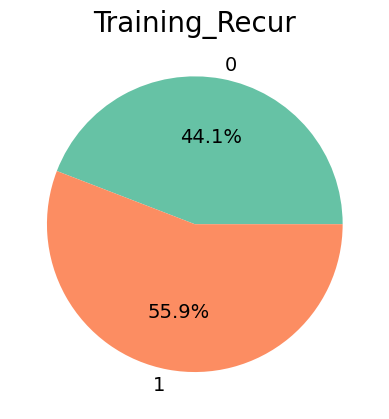

In [33]:
test = pd.read_csv('./data/post/HCC OP 20230511 train_post.csv')
# 绘制train['recur']的圆饼图
counts = test['Recur'].value_counts().to_dict()
counts_keys = list(counts.keys())
counts_keys.sort()
counts = {k: counts[k] for k in counts_keys}
fig, ax = plt.subplots()
colors = sns.color_palette("Set2")[:len(counts.keys())]
ax.set_title('Training_Recur', fontdict={'size': 20})
ax.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})
#plt.savefig('./data_cluster/統計圖表/train分佈.png')
plt.show()

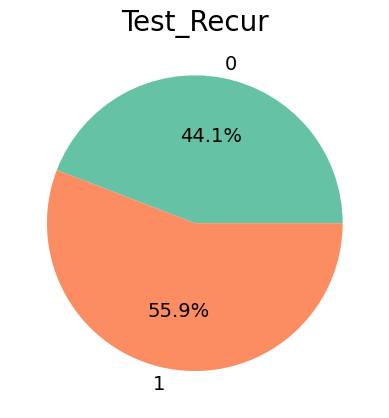

In [34]:
test = pd.read_csv('./data/post/HCC OP 20230511 test_post.csv')
# 绘制train['recur']的圆饼图
counts = test['Recur'].value_counts().to_dict()
counts_keys = list(counts.keys())
counts_keys.sort()
counts = {k: counts[k] for k in counts_keys}
fig, ax = plt.subplots()
colors = sns.color_palette("Set2")[:len(counts.keys())]
ax.set_title('Test_Recur', fontdict={'size': 20})
ax.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})
#plt.savefig('./data_cluster/統計圖表/train分佈.png')
plt.show()

查看資料集是否有顯著差異

In [35]:
from scipy.stats import ttest_ind
# 計算各欄位的 p-value
p_values = []
for column in combined_train.columns:
    # 執行 t 檢定
    _, p_value = ttest_ind(combined_train[column], combined_test[column])
    p_values.append(p_value)

# 打印 p-value
for column, p_value in zip(combined_train.columns, p_values):
    #print(f"{column}: p-value = {p_value}")
    if p_value < 0.05:
        print(column)

補值

In [36]:
df = pd.read_csv('./data/post/HCC OP 20230511 train_post.csv')
df = df.drop(['OP&RFA Data ID','Eachcase Nan count'], axis=1)

# 初始化 KNNImputer 物件
imputer = KNNImputer(n_neighbors=200)

# 執行 KNN 補值
df_imputed = imputer.fit_transform(df)

# 將補值後的結果轉換為 DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

# 將補值後的結果加入原始資料集中
df = df_imputed
df.to_csv('./data/post/HCC OP 20230511 train_post_input.csv',index=False)
print(len(df))

1033


In [37]:
train_df = pd.read_csv("./data/post/HCC OP 20230511 train_post_input.csv")
test_df = pd.read_csv("./data/post/HCC OP 20230511 test_post.csv")
test_df = test_df.drop(['OP&RFA Data ID','Eachcase Nan count'], axis=1)
#先將test資料切分出有缺值跟無缺值
known_data = test_df.dropna()
missing_data = test_df[test_df.isna().any(axis=1)]

# 將空字串替換成 NaN 值
#missing_data.replace(' ', np.nan, inplace=True)
missing_data.head()

,Milan_out,Age,Sex,"Image_Vasulcar_invasion(Portal vein,Hepatic vein)",BCLC,Child_Class,Weight,Height,BMI,WBC,...,Tumor number,ALBIscore,ALBIgrade,Histologic grade,MVI,Inflammation,Ishak,Steatosis grade,Recur,Recurrence free survival
0,1,30.73,2,0,2,1,67.6,168.0,23.951247,8100,...,2,-3.034,1.0,2.0,1.0,NaN,6.0,1.0,1,5.03
20,1,38.25,2,0,1,1,60.2,161.0,23.224413,5500,...,1,-3.347,1.0,2.0,1.0,1.0,1.0,NaN,1,19.93
26,1,52.81,1,0,1,1,86.1,167.1,30.835447,5900,...,1,-2.972,1.0,2.5,1.0,1.0,1.0,1.0,1,8.30
29,1,36.00,2,0,1,1,NaN,NaN,NaN,4500,...,1,-2.264,2.0,2.0,1.0,0.0,0.0,NaN,1,8.03
30,1,80.81,1,0,1,1,61.9,167.3,22.115602,4500,...,1,-2.248,2.0,2.0,1.0,1.0,0.0,0.0,0,29.83


In [38]:
k = 200
imputer = KNNImputer(n_neighbors=k)

for i in range(1,len(missing_data)+1):
    nan_df = missing_data.iloc[i-1:i, :]
    #train_df = pd.concat([train_df,nan_df], ignore_index=True)
    train_df = train_df.append(nan_df)
    
    imputed = imputer.fit_transform(train_df)
    # 進行KNN補值
    df_imputed = pd.DataFrame(imputed, columns=train_df.columns)
    # 提取最後一列資料成為新的 Series 物件
    last_row = df_imputed.iloc[-1,:]
    #known_data = pd.concat([known_data,last_row], ignore_index=True)
    known_data = known_data.append(last_row)
    # 刪除 DataFrame 的最後一列資料
    train_df = train_df.drop(train_df.index[-1])
known_data.to_csv("./data/post/HCC OP 20230511 test_post_input.csv",index=False)

C:\Users\User\AppData\Local\Temp\ipykernel_11204\1715564863.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(nan_df)
C:\Users\User\AppData\Local\Temp\ipykernel_11204\1715564863.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  known_data = known_data.append(last_row)
C:\Users\User\AppData\Local\Temp\ipykernel_11204\1715564863.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(nan_df)
C:\Users\User\AppData\Local\Temp\ipykernel_11204\1715564863.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  known_data = known_data.append(last_row)
C:\Users\User\AppData\Local\Temp\ipykernel

增加衍生特徵

In [44]:
df = pd.read_csv('./data/post/HCC OP 20230511 train_post_input.csv')
column = 'PLAT'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 120000, 0, np.where(df[column] < 150000, 1, 2))
column = 'PTINR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1.1, 1, 0)
column = 'ALB'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 3.5, 0, np.where(df[column] < 3.8, 1, 2))
column = 'CR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1.2, 1, 0)
column = 'BILI'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 1.2, 0, np.where(df[column] < 2, 1, 2))
column = 'ALT'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 40, 0, np.where(df[column] < 80, 1, 2))
column = 'AST'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 40, 0, np.where(df[column] < 80, 1, 2))
column = 'AFP'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 7, 0,
                               np.where(df[column] < 10, 1,
                                        np.where(df[column] < 20, 2,
                                                 np.where(df[column] < 200, 3, 
                                                          np.where(df[column] < 400, 4,5)))))
column = 'Age'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 50, 0,
                               np.where(df[column] < 60, 1,
                                        np.where(df[column] < 65, 2, 3, 
                                                          )))
column = 'BMI'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 23, 0,
                               np.where(df[column] < 25, 1,
                                        np.where(df[column] < 27, 2,
                                                 np.where(df[column] < 27.5, 3, 
                                                          np.where(df[column] < 30, 4,5)))))
column = 'Tumor size'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 2, 0,
                               np.where(df[column] < 3, 1,
                                        np.where(df[column] < 4, 2,
                                                 np.where(df[column] < 5, 3, 
                                                          np.where(df[column] < 10, 4,5)))))
column = 'Tumor number'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1, 1, 0)
column = 'NLR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 2.5, 0,
                               np.where(df[column] < 3, 1,
                                        np.where(df[column] < 4, 2,
                                                 np.where(df[column] < 5, 3,4))))
column = 'FIB4'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 3.25, 1, 0)
column = 'Histologic grade'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 2, 0,
                               np.where(df[column] < 2.5, 1,
                                        np.where(df[column] < 3, 2,3
                                                 )))
column = 'Steatosis grade'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 0, 1, 0)

df.to_csv('./data/post/HCC OP 20230511 train_post_input_derived features.csv',index=False)

In [45]:
df = pd.read_csv('./data/post/HCC OP 20230511 train_post_input_derived features.csv')
columns_to_ln = ['PLAT', 'BUN', 'CR','ALT','AST','AFP','GGT','CHOL','ALK-P', 'LDH','GLU','Histologic grade']

# 對指定欄位進行 ln 轉換並存儲為新欄位
for column in columns_to_ln:
    new_column_name = 'ln' + column
    df[new_column_name] = np.log(df[column])

df.to_csv('./data/post/HCC OP 20230511 train_post_input_derived features.csv',index=False)

In [46]:
train = pd.read_csv('./data/post/HCC OP 20230511 train_post_input_derived features.csv')
test = pd.read_csv('./data/post/HCC OP 20230511 test_post_input_derived features.csv')
p_values = []
for column in train.columns:
    # 執行 t 檢定
    _, p_value = ttest_ind(train[column], test[column])
    p_values.append(p_value)

# 打印 p-value
for column, p_value in zip(train.columns, p_values):
    #print(f"{column}: p-value = {p_value}")
    if p_value < 0.05:
        print(column)

正規化

In [47]:
raw_df = pd.read_csv('./data/post/HCC OP 20230511 train_post_input_derived features.csv')
raw_df_test = pd.read_csv('./data/post/HCC OP 20230511 test_post_input_derived features.csv')
display(raw_df.head())

,Milan_out,Age,Sex,"Image_Vasulcar_invasion(Portal vein,Hepatic vein)",BCLC,Child_Class,Weight,Height,BMI,WBC,...,lnCR,lnALT,lnAST,lnAFP,lnGGT,lnCHOL,lnALK-P,lnLDH,lnGLU,lnHistologic grade
0,1.0,56.44,1.0,0.0,2.0,1.0,60.2,157.0,24.422897,6100.0,...,-0.210721,3.044522,3.555348,1.425515,3.091042,4.753590,4.143135,5.225747,4.532599,0.916291
1,1.0,81.44,1.0,0.0,1.0,1.0,71.3,168.3,25.172207,6300.0,...,0.157004,3.610918,4.204693,11.234419,4.426701,5.145923,4.644247,5.556654,4.668333,1.098612
2,1.0,87.53,1.0,0.0,1.0,1.0,51.9,158.5,20.658978,6900.0,...,-0.020203,4.543295,5.062595,5.470967,4.488636,5.308268,4.736198,5.686975,4.510860,0.916291
3,0.0,64.72,2.0,0.0,1.0,1.0,48.1,149.6,21.492250,6300.0,...,-0.462035,3.401197,3.433987,6.333706,3.091042,5.081404,4.290459,5.669881,5.288267,0.916291
4,1.0,57.45,1.0,1.0,3.0,1.0,61.5,162.7,23.232717,6600.0,...,-0.314711,4.369448,3.295837,6.391917,3.931826,5.023881,4.804021,4.919981,5.209486,0.693147


In [48]:
X_train = raw_df.drop(columns=['Recur', 'Recurrence free survival'])
y_train = raw_df[['Recur', 'Recurrence free survival']]
X_test = raw_df_test.drop(columns=['Recur', 'Recurrence free survival'])
y_test = raw_df_test[['Recur', 'Recurrence free survival']]

In [51]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
display(scaled_X_train.tail())
display(y_train.tail())

,Milan_out,Age,Sex,"Image_Vasulcar_invasion(Portal vein,Hepatic vein)",BCLC,Child_Class,Weight,Height,BMI,WBC,...,lnCR,lnALT,lnAST,lnAFP,lnGGT,lnCHOL,lnALK-P,lnLDH,lnGLU,lnHistologic grade
1028,1.17715,-0.108194,-0.539676,-0.234858,1.344577,-0.121387,1.001973,-0.285461,1.450746,-0.427309,...,1.005086,0.513001,2.235955,2.589738,2.747474,0.280485,2.014478,0.474631,0.095904,1.416006
1029,-0.84951,-0.348056,-0.539676,-0.234858,-0.128327,-0.121387,0.142135,0.234727,0.029627,0.509719,...,0.248493,0.332779,-0.957517,-0.374973,-0.179128,0.057085,-0.613983,-0.629818,-0.431825,0.634366
1030,-0.84951,-0.558768,-0.539676,-0.234858,-0.128327,-0.121387,0.584824,0.445279,0.401823,0.181759,...,-0.276778,-0.152915,-0.206314,-0.851114,-0.091028,0.084479,-0.807184,0.105924,-0.105933,-0.322283
1031,-0.84951,0.646373,-0.539676,-0.234858,-0.128327,-0.121387,-1.041206,-0.681794,-0.843602,0.322313,...,0.326824,2.505095,2.630853,-0.111263,2.013674,2.119435,1.800583,-0.171573,0.127862,-0.322283
1032,-0.84951,-0.109859,-0.539676,-0.234858,-0.128327,-0.121387,0.142135,-1.115284,1.019964,0.181759,...,-1.282438,-0.243854,-0.736922,-0.746024,-0.209970,-1.519065,-0.889431,0.083395,0.692675,-3.293907


,Recur,Recurrence free survival
1028,1.0,2.17
1029,0.0,27.87
1030,1.0,45.17
1031,0.0,20.33
1032,0.0,31.53


In [52]:
scaled_data = pd.concat([scaled_X_train, y_train], axis=1)
scaled_data_test = pd.concat([scaled_X_test, y_test], axis=1)
scaled_data.to_csv('./data/post/HCC OP 20230511 train_post_input_derived features_std.csv',index=False)
scaled_data_test.to_csv('./data/post/HCC OP 20230511 test_post_input_derived features_std.csv',index=False)
joblib.dump(scaler, './data/post/HCC OP 20230511 train_post_input_derived features_scaler.bin')

['./data/post/HCC OP 20230511 train_post_input_derived features_scaler.bin']

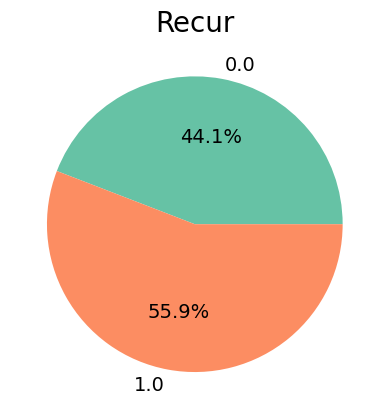

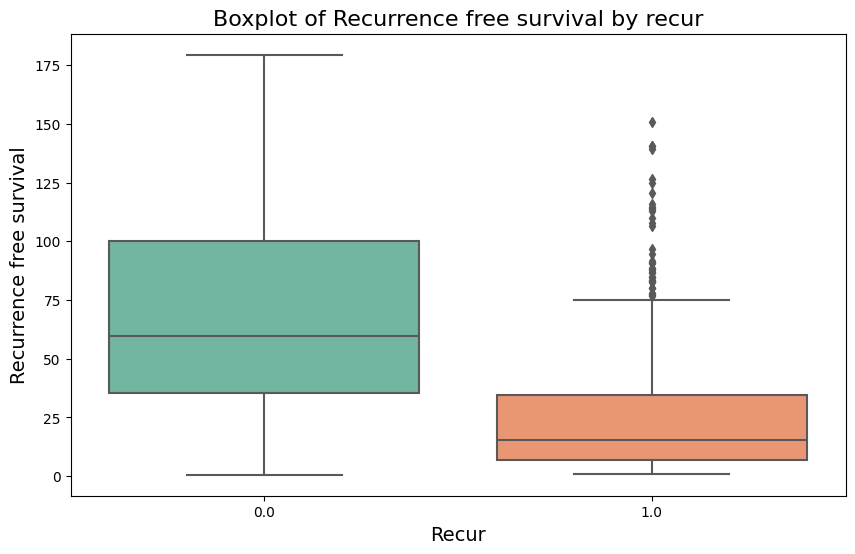

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
test = pd.read_csv('./data/post/HCC OP 20230511 train_post_input_derived features_std.csv')
# 绘制train['recur']的圆饼图
counts = test['Recur'].value_counts().to_dict()
counts_keys = list(counts.keys())
counts_keys.sort()
counts = {k: counts[k] for k in counts_keys}
fig, ax = plt.subplots()
colors = sns.color_palette("Set2")[:len(counts.keys())]
ax.set_title('Recur', fontdict={'size': 20})
ax.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})
plt.show()

# 绘制train['Early recurrence free survival']和train['Early recur']的箱线图
plt.figure(figsize=(10, 6))  # 设置图形的大小（可选）
sns.boxplot(x=test["Recur"], y=test["Recurrence free survival"], palette=sns.color_palette("Set2"))
plt.xlabel('Recur', fontsize=14)  # 设置x轴标签
plt.ylabel('Recurrence free survival', fontsize=14)  # 设置y轴标签
plt.title('Boxplot of Recurrence free survival by recur', fontsize=16)  # 设置图形标题
plt.show()

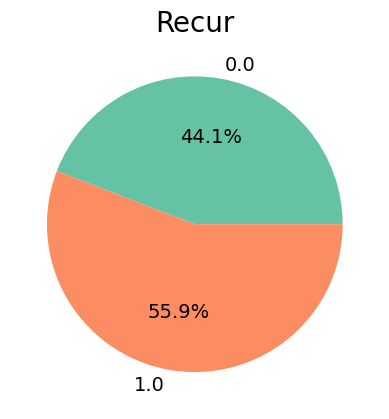

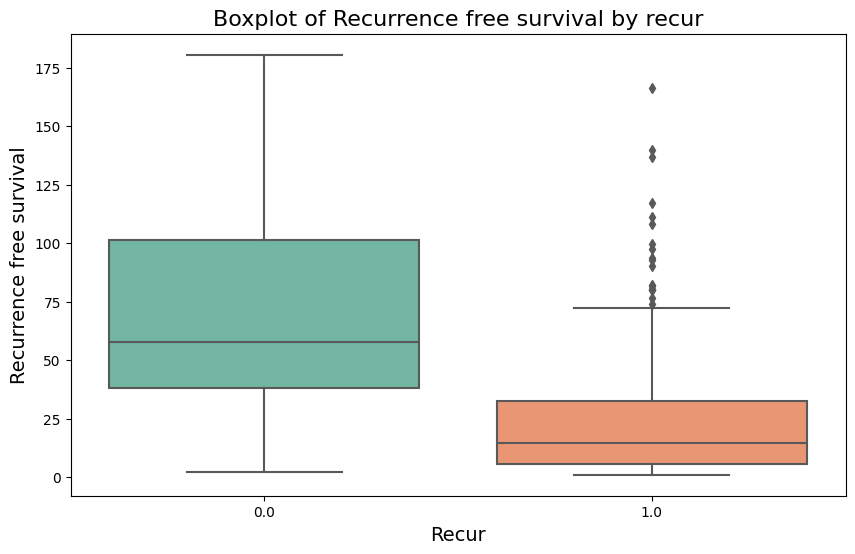

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
test = pd.read_csv('./data/post/HCC OP 20230511 test_post_input_derived features_std.csv')
# 绘制train['recur']的圆饼图
counts = test['Recur'].value_counts().to_dict()
counts_keys = list(counts.keys())
counts_keys.sort()
counts = {k: counts[k] for k in counts_keys}
fig, ax = plt.subplots()
colors = sns.color_palette("Set2")[:len(counts.keys())]
ax.set_title('Recur', fontdict={'size': 20})
ax.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})
plt.show()

# 绘制train['Early recurrence free survival']和train['Early recur']的箱线图
plt.figure(figsize=(10, 6))  # 设置图形的大小（可选）
sns.boxplot(x=test["Recur"], y=test["Recurrence free survival"], palette=sns.color_palette("Set2"))
plt.xlabel('Recur', fontsize=14)  # 设置x轴标签
plt.ylabel('Recurrence free survival', fontsize=14)  # 设置y轴标签
plt.title('Boxplot of Recurrence free survival by recur', fontsize=16)  # 设置图形标题
plt.show()